In [1]:
import sys
sys.path.insert(0, "../")

import cv2
import mmcv
import mmengine
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path
from scipy.spatial.transform import Rotation

In [2]:
import virtual_camera as vc

In [3]:
def imshow(img, figsize=(16, 9)):
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.show()

In [4]:
info_file = '../data/20230823_110018/mv_4d_infos.pkl'

scenes = mmengine.load(info_file)

In [5]:
scene = scenes['20230823_110018']

In [6]:
scene['meta_info']

{'description': 'some information with this scene',
 'space_range': {'map': [36, -12, -12, 12, 10, -10],
  'det': [36, -12, -12, 12, 10, -10],
  'occ': [36, -12, -12, 12, 10, -10]},
 'time_range': 2}

In [7]:
data_root = Path('../data/')

In [8]:
scene.keys(), scene['scene_info']['camera_mask'].keys()

(dict_keys(['scene_info', 'meta_info', 'frame_info']),
 dict_keys(['VCAMERA_FISHEYE_BACK', 'VCAMERA_FISHEYE_FRONT', 'VCAMERA_FISHEYE_LEFT', 'VCAMERA_FISHEYE_RIGHT', 'VCAMERA_PERSPECTIVE_BACK_LEFT', 'VCAMERA_PERSPECTIVE_BACK', 'VCAMERA_PERSPECTIVE_BACK_RIGHT', 'VCAMERA_PERSPECTIVE_FRONT_LEFT', 'VCAMERA_PERSPECTIVE_FRONT', 'VCAMERA_PERSPECTIVE_FRONT_RIGHT']))

In [9]:
scene['scene_info']['camera_mask']['VCAMERA_FISHEYE_FRONT']

'20230823_110018/fisheye_ego_mask/VCAMERA_FISHEYE_FRONT_MASK/1692759619664_ego_mask.jpg'

# Test Dataset

In [13]:
from prefusion.dataset.dataset import GroupBatchDataset
from prefusion.dataset.transform import RenderIntrinsic, RandomRenderExtrinsic, RandomImageISP, RandomRotationSpace

In [41]:
gbd = GroupBatchDataset(
    name='MvParkingTest',
    data_root=Path('../data/'),
    info_path=Path('../data/20230823_110018/mv_4d_infos.pkl'),
    dictionary={},
    transformable_keys=[
        'camera_images'
    ],
    transforms=[
        RenderIntrinsic(
            resolutions=dict(
                VCAMERA_FISHEYE_FRONT=(384, 224),
                VCAMERA_FISHEYE_LEFT=(384, 224)
            )
        ),
        # RandomImageISP(scope='batch'),
        RandomRotationSpace(
            prob=1.0,
            angles=[0, 0, 10],
            prob_inverse_cameras_rotation=1.0,
            scope='group'
        )
    ],
    phase='train',
    batch_size=1,
    group_size=2
)

In [42]:
len(gbd)

50

In [43]:
# frame_dict

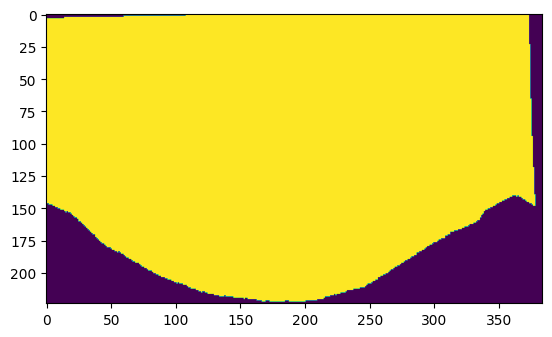

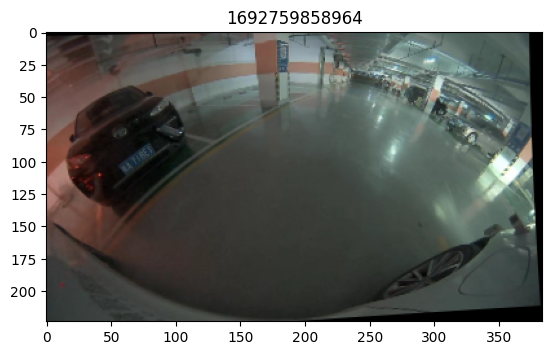

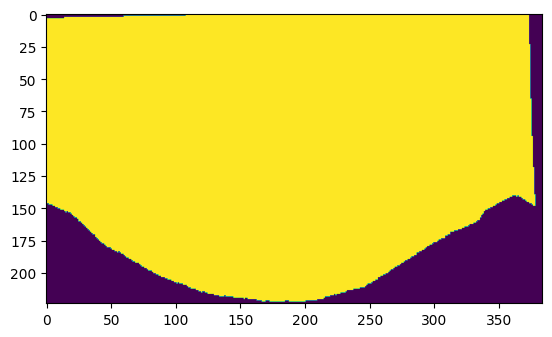

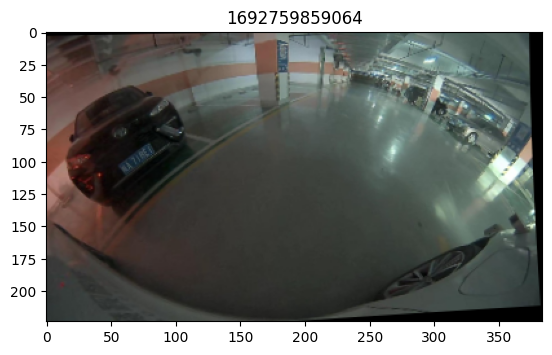

In [45]:
group_batch = gbd[0]
for frame_batch in group_batch:
    for frame_dict in frame_batch:
        # print(frame_dict['frame_id'], end=', ')
        test_image = frame_dict['transformables']['camera_images']['VCAMERA_FISHEYE_LEFT']
        plt.imshow(test_image.data['ego_mask']); plt.show()
        # plt.subplot()
        plt.title(frame_dict['frame_id'])
        plt.imshow(test_image.data['img'][..., ::-1])
        plt.show()
    

# gen indices

In [ ]:
indices = []
for scene_id in scenes:
    for frame in scenes[scene_id]['frame_info']:
        indices.append('/'.join([scene_id, frame]))

In [ ]:
indices[:5]

# gen an Image transformable

In [ ]:
from src.dataset.transform import CameraImage, Bbox3D

In [ ]:
def get_cam_type_from_sensor_name(sensor_name):
    if 'perspective' in sensor_name.lower():
        return 'PerspectiveCamera'
    elif 'fisheye' in sensor_name.lower():
        return 'FisheyeCamera'
    else:
        raise ValueError('Unknown camera type')

In [ ]:
sensors = scene['scene_info']['calibration'].keys()

for sensor in sensors:
    print(sensor)

In [ ]:
sorted(scene['frame_info'].keys())[:5]

In [ ]:
ss = sorted(scene['frame_info'].keys())
ss[:10]

In [ ]:
def index_frame(timestamp, sequence):
    for t in sequence:
        if int(timestamp) <= int(t):
            return sequence.index(t)

In [ ]:
a = index_frame('1692759621555', ss)

In [ ]:
a

In [ ]:
sequence_modes = [
    dict(mode='INTERVAL',
         args=dict(interval=1,
                   nframes=3)),
    dict(mode='SINGLE'),
    dict(mode='SEQUENTIAL',
         args=dict(duration=3))
]

sequence_modes[0]['mode']

In [ ]:
sensor_name = 'VCAMERA_PERSPECTIVE_FRONT'


img_data = {
    'cam_id': sensor_name,
    'cam_type': get_cam_type_from_sensor_name(sensor_name)
}
img_data.update(scene['scene_info']['calibration'][sensor_name])
img_data['img'] = mmcv.imread(data_root / scene['frame_info']['1692759619664']['camera_image'][sensor_name])
img_data['ego_mask'] = mmcv.imread(data_root / scene['scene_info']['camera_mask'][sensor_name + '_MASK'], flag='grayscale')

In [ ]:
img_data

In [ ]:
# plt.figure(figsize=(32, 18))
# imshow(img_data['img'][..., ::-1])
# imshow(img_data['ego_mask'])

In [ ]:
img_front = CameraImage(img_data)

In [ ]:
del_R = Rotation.from_euler('xyz', [0, 0, 0], degrees=True).as_matrix()
del_t = np.array([0, 0, 0])
del_extrinsic = [del_R, del_t]

img_front.render_extrinsic(del_extrinsic)

# imshow(img_front.data['img'][..., ::-1])

In [ ]:
isinstance(img_front, CameraImage)

In [ ]:
img_data['intrinsic']

In [ ]:
resolution = (768, 256)
intrinsic = [383.5, 127.5, 384, 384]

img_front.render_intrinsic(resolution=resolution, intrinsic=intrinsic)

plt.imshow(img_front.data['img'][..., ::-1]); plt.show()
plt.imshow(img_front.data['ego_mask']); plt.show()

In [ ]:
flip_mat = np.eye(3)
flip_mat[1, 1] = -1

img_front.flip_3d(flip_mat)

imshow(img_front.data['img'][..., ::-1])

# DEBUG MIRROR ROTATION

In [ ]:
from scipy.spatial.transform import Rotation

R = Rotation.from_euler('xyz', [-90, 0, -90], degrees=True).as_matrix()
Rx = Rotation.from_euler('x', -90, degrees=True).as_matrix()
Ry = Rotation.from_euler('y', 0, degrees=True).as_matrix()
Rz = Rotation.from_euler('z', -90, degrees=True).as_matrix()

In [ ]:
from scipy.spatial.transform import Rotation

Rotation.from_euler('xyz', [0, 10, 90], degrees=True).as_euler('XYZ', degrees=True)

In [ ]:
R, Rz @ Ry @ Rx

In [ ]:
# ang_x, ang_y, ang_z = Rotation.from_matrix(R).as_euler('xyz', degrees=True)
# print(ang_z)
# ang_z_ = -180 - ang_z

# R_ = Rotation.from_euler('xyz', [ang_x, ang_y, ang_z_], degrees=True).as_matrix()

# print(np.round(R_, 3))

In [ ]:
Rotation.from_euler('xyz', [180, 0, 0], degrees=True).as_matrix()

In [ ]:
flip_mat = np.eye(3)
# flip_mat[0, 0] = -1

# flip_mat[0, 0] = -1
flip_mat[1, 1] = -1
# flip_mat[2, 2] = -1

R = Rotation.from_euler('xyz', [-1, 2, 45], degrees=True).as_matrix()
print(np.round(R, 3))
# print(flip_mat)

R_mirror = flip_mat.T @ R @ flip_mat

print(np.round(R_mirror, 3))

print(Rotation.from_matrix(R_mirror).as_euler('xyz', degrees=True))

In [ ]:
flip_mat.T @ flip_mat

In [ ]:
np.round(Rotation.from_euler('xyz', [-1, 2, 45], degrees=True).as_matrix(), 3), np.round(Rotation.from_euler('xyz', [1, 2, -45], degrees=True).as_matrix(), 3)

In [ ]:
np.round(Rotation.from_euler('xyz', [-90, 0, 135], degrees=True).as_matrix(), 3), np.round(Rotation.from_euler('xyz', [-90, 0, -225], degrees=True).as_matrix(), 3)

In [ ]:
import random
random.uniform(0.9, 1.1)

In [ ]:
Rotation.from_euler('xyz', [-90, 0, 0], degrees=True).as_euler('xyz', degrees=True), Rotation.from_euler('xyz', [-90, 0, -180], degrees=True).as_euler('xyz', degrees=True)

In [ ]:
front_camp.adjust_sharpness(sharpness=5)
plt.imshow(cam_info['img'][..., ::-1])

In [ ]:
cam_info['intrinsic']

In [ ]:
cx, cy, fx, fy, *_ = cam_info['intrinsic']
_

In [ ]:
len(scene['frame_info'].keys())

# gen a Bbox3D transformable

In [ ]:
def box3d_rt_to_points(rt):
    R, t, size = rt

def box3d_points_to_rt(points):
    pass

In [ ]:
boxes = scene['frame_info']['1692759619664']['3d_boxes']

In [ ]:
box_data = boxes[0]
box_data

In [ ]:
test_box3d = Bbox3D(box_data, {0: 'car', 1: 'pedestrian', 2: 'cyclist'})

In [ ]:
test_box3d.flip_3d(flip_mat)

In [ ]:
test_box3d.data

# gen a Polyline3D transformable

In [ ]:
from src.dataset.transform import Polyline3D

In [ ]:
frame_ids = list(scene['frame_info'].keys())

polylines = scene['frame_info'][frame_ids[0]]['3d_polylines']

In [ ]:
# for p in polylines:
#     print(p['class'])
polyline_data = polylines[3]
polyline_data

In [ ]:
poly3d_test = Polyline3D(polyline_data, {})

In [ ]:
poly3d_test.data

In [ ]:
poly3d_test.flip_3d(flip_mat)

In [ ]:
poly3d_test

In [ ]:
poly3d_test.data

In [ ]:
import inspect
import random

In [ ]:
class Transform:
    def __init__(self, scope="item"):
        assert scope.lower() in ["item", "batch"]
        self.scope = scope.lower()

    def __call__(self, *args, **kwargs):
        raise NotImplementedError



class RandomImageISP(Transform):
    def __init__(self, *, 
                #  adjust_brightness={"prob": 0.5, "range": (0.5, 2.0)},
                #  adjust_saturation={"prob": 0.5, "range": (0.0, 2.0)},
                #  adjust_contrast={"prob": 0.5, "range": (0.5, 2.0)},
                #  adjust_hue={"prob": 0.5, "range": (-0.5, 0.5)},
                #  adjust_sharpness={"prob": 0.5, "range": (0.0, 2.0)},
                #  posterize={"prob": 0.5, "bits": (4, 8)},
                #  channel_shuffle={"prob": 0.5},
                #  auto_contrast={"prob": 0.2},
                 solarize={"prob": 1},
                #  imequalize={"prob": 0.1},
                 random_sequence=True,
                 scope="item",  **kwargs):
        super().__init__(scope=scope)
        transforms = list(inspect.signature(self.__init__).parameters.keys())[:-3]
        self.random_sequence = random_sequence
        self.sequence = []
        for transform in transforms:
            self.sequence.append({transform: eval(f"{transform}")})
        self.kwargs = kwargs
    
    def __call__(self, *transformables, **kwargs):
        if self.random_sequence:
            random.shuffle(self.sequence)
        
        sequence = {}
        for transform in self.sequence:
            sequence.update(transform)
        
        for transformable in transformables:
            if transformable is not None:
                for transform_func in sequence:
                    print(transform_func)
                    prob = sequence[transform_func]['prob']
                    if random.random() < prob:
                        if 'range' in sequence[transform_func]:
                            random_value = random.uniform(*sequence[transform_func]['range'])
                            getattr(transformable, transform_func)(random_value, **kwargs)
                        elif 'bits' in sequence[transform_func]:
                            random_value = random.randint(*sequence[transform_func]['bits'])
                            getattr(transformable, transform_func)(random_value, **kwargs)
                        else:
                            getattr(transformable, transform_func)(**kwargs)
        
        return transformables

In [ ]:
isp = RandomImageISP()

In [ ]:
isp(img_front)

In [ ]:
plt.imshow(img_front.data['img'][..., ::-1])

# gen a OCCSDF Transformable

- left 25.6m
- right 25.6m
- front 38.4m
- bottom 12.8m

In [ ]:
import numpy as np

In [ ]:
test_occ = np.zeros((5, 360, 120))
H, W = test_occ.shape[1:]
uu, vv = np.meshgrid(np.arange(W), np.arange(H))

print(uu.shape)


In [ ]:
uu, vv

# Dataset Sequence Batch Group Sampler

In [ ]:
isinstance([], (list, tuple))

In [ ]:
scenes['20230823_110018']['frame_info'].keys()

In [ ]:
import random
# from torch.utils.data import IterableDataset, BatchSampler

In [ ]:
class MvSequenceDataset:
    def __init__(self, bucket_size=10, phase='train') -> None:
        self.scenes = {'{:03d}'.format(g): ['{:05d}'.format(i) for i in range(50)] for g in range(10)}
        self.bucket_size = bucket_size
        assert phase in ['train', 'val', 'test']
        self.phase = phase
        if self.phase in ['train']:
            self._sample_train_indices()
        if self.phase in ['val', 'test']:
            self._sample_test_indices()
    
    def __len__(self):
        size = 0
        for scene_id in self.scenes:
            size += len(self.scenes[scene_id])
        if self.phase in ['train']:
            return size * self.bucket_size
        if self.phase in ['val', 'test']:
            return size
    

    def _sample_train_indices(self):
        scenes = list(self.scenes.keys())
        grouped_buckets = []
        for scene_id in scenes:
            buckets = []
            for i in range(len(self.scenes[scene_id])):
                i_start = i - self.bucket_size
                bucket = []
                for j in range(i_start, i):
                    bucket.append('{}_{}'.format(scene_id, self.scenes[scene_id][max(0, j)]))
                buckets.append(bucket)
            random.shuffle(buckets)
            grouped_buckets.extend(buckets)
        random.shuffle(grouped_buckets)
        self.grouped_buckets = grouped_buckets


    def _sample_test_indices(self):
        scenes = list(self.scenes.keys())
        # random.shuffle(scenes)
        grouped_buckets = []
        for scene_id in scenes:
            bucket = []
            for frame_id in self.scenes[scene_id]:
                bucket.append('{}_{}'.format(scene_id, frame_id))
            grouped_buckets.append(bucket)
        self.grouped_buckets = grouped_buckets
    
    
    def __getitem__(self, index):
        if index >= len(self):
            if self.phase in ['train']:
                self._sample_train_indices()
            if self.phase in ['val', 'test']:
                self._sample_test_indices()
            raise IndexError
        group_index = index // self.bucket_size
        bucket_index = index % self.bucket_size
        return self.grouped_buckets[group_index][bucket_index]

In [ ]:
class MvGroupBacthSampler:

    def __init__(self, group_sampler, batch_size, drop_last=True):
        self.sampler = group_sampler
        # batch_size better lower than len(self.sampler.grouped_buckets)
        self.batch_size = batch_size
        # self.buffer = []
        # self.batch_buffer = [[] for _ in range(self.batch_size)]
    

    def __len__(self):
        return len(self.sampler.grouped_buckets) * self.sampler.bucket_size // self.batch_size


    # def __getitem__(self, batch_index):
    def __iter__(self):
        random.shuffle(self.sampler.grouped_buckets)
        batched_group = [[], ] * self.batch_size
        batch_index = 0
        for group_id in range(len(self.sampler.grouped_buckets)):
            batched_group[batch_index] = self.sampler.grouped_buckets[group_id]
            batch_index += 1
            if batch_index == self.batch_size:
                for frame_id in range(self.sampler.bucket_size):
                    batch = []
                    for b in range(self.batch_size):
                        batch.append(batched_group[b][frame_id])
                    yield batch
                batch_index = 0
                batched_group = [[], ] * self.batch_size


In [ ]:
dd = MvSequenceDataset()
bs = MvGroupBacthSampler(dd, batch_size=4)

In [ ]:
len(dd), len(bs)

In [ ]:
for i in dd:
    print(i)

In [ ]:
for i in bs:
    print(i)

In [ ]:
class A:
    pass

class B(A):
    pass

In [ ]:
isinstance(B(), B)

In [ ]:
# group_seed = 0
random.seed('group_0')
random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)

In [ ]:
random.seed(0)
random.uniform(0, 1)

In [ ]:
random.uniform(0, 1)

In [ ]:
random.uniform(0, 1)

In [ ]:
str(['s'])

In [ ]:
random.choices(population=['a', 'b', 'c'], weights=[0.1, 0.2, 0.7])

In [ ]:
ll = range(20)
group_size=1
frame_interval=1

In [ ]:
group_interval = group_size * frame_interval
# first_end_id = random.randint(frame_interval, group_interval)
first_end_id = group_interval
last_end_id = len(ll)

end_inds = []

for i in range(frame_interval):
    first_id = first_end_id + i
    end_inds.extend(ll[first_id::group_interval])

end_inds = sorted(end_inds)

if end_inds[-1] < last_end_id:
    end_inds.append(last_end_id)

In [ ]:
end_inds

In [ ]:
for end_ind in end_inds:
    index_list = list(range(end_ind - group_interval, end_ind)[::frame_interval])
    print(index_list)

In [1]:
import sys
sys.path.insert(0, "../")

import cv2
import mmcv
import mmengine
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path
from scipy.spatial.transform import Rotation
from torch.utils.data import DataLoader

from torch.utils.data.distributed import DistributedSampler

from src.dataset.dataset import GroupBatchDataset
from src.dataset.distributed import DistributedGroupSampler
# from src.dataset.distributed import DistributedBatchSampler
# from src.dataset.dataloader import EventDataLoader

from src.dataset.transform import RandomImageISP, RandomRotationSpace

In [2]:
# from copy import copy

In [34]:
gbd = GroupBatchDataset(
    name='MvParkingTest',
    data_root=Path('../data/'),
    info_path=Path('../data/20230823_110018/mv_4d_infos.pkl'),
    dictionary={},
    transformable_keys=[
        'camera_images'
    ],
    transforms=[
        # RandomImageISP(scope='batch'),
        RandomRotationSpace(
            prob=1.0,
            angles=[0, 0, 10],
            prob_inverse_cameras_rotation=1.0,
            scope='group'
        )
    ],
    phase='train',
    batch_size=3,
    group_size=10
)

In [35]:
# copy(gbd) is gbd

In [36]:
len(gbd.groups), len(gbd)

(10, 4)

In [38]:
group_batch = gbd[3]
for frame_batch in group_batch:
    for frame_dict in frame_batch:
        print(frame_dict['frame_id'], end=', ')
        # test_image = frame_dict['transformables']['camera_images'][0]
        # plt.imshow(test_image.data['ego_mask']); plt.show()
        # plt.title(frame_dict['frame_id'])
        # plt.imshow(test_image.data['img'][..., ::-1]); plt.show()
    print()

1692759858564, 
1692759858664, 
1692759858764, 
1692759858864, 
1692759858964, 
1692759859064, 
1692759859164, 
1692759859264, 
1692759859364, 
1692759859464, 


In [22]:
s0 = DistributedSampler(gbd, num_replicas=2, rank=0)
s1 = DistributedSampler(gbd, num_replicas=2, rank=1)
ss0 = DistributedGroupSampler(gbd, num_replicas=2, rank=0)
ss1 = DistributedGroupSampler(gbd, num_replicas=2, rank=1)

In [10]:
# for ind in ss0:
#     print(ind)

# for ind in ss1:
#     print(ind)

# Implement a special collate function for the dataloader

In [25]:
def collate_generator(batch):
    return batch[0]

dataloader = DataLoader(
    dataset=gbd,
    collate_fn=collate_generator,
)

In [26]:
for ind, batch in enumerate(dataloader):
    if ind > 5:
        break
    for frame_batch in batch:
        for frame_dict in frame_batch:
            print(frame_dict['frame_id'], end=', ')
            # test_image = frame_dict['transformables']['camera_images'][0]
            # plt.title(frame_dict['frame_id'])
            # plt.imshow(test_image.data['img']); plt.show()
        print()
    # for frame_dict in batch:
    #     print(frame_dict['frame_id'], end='; ')
    # print()

1692759856664, 1692759850664, 
1692759856764, 1692759850764, 
1692759859264, 1692759849564, 
1692759859364, 1692759849664, 
1692759857664, 1692759855464, 
1692759857764, 1692759855564, 
1692759849864, 1692759850864, 
1692759849964, 1692759850964, 
1692759851064, 1692759850264, 
1692759851164, 1692759850364, 
1692759853064, 1692759849664, 
1692759853164, 1692759849764, 


In [ ]:
# for ind, batch in enumerate(gbd):
#     if ind > 5:
#         break
#     for frame_dict in batch:
#         print(frame_dict['scene_id'], frame_dict['frame_id'], frame_dict['prev_exists'], end='; ')
#     print()

In [ ]:
# s0 = DistributedGroupSampler(gbd, num_replicas=2, rank=0)
# s1 = DistributedGroupSampler(gbd, num_replicas=2, rank=1)

In [ ]:
# s0.rank_chunks[0][0], s1.rank_chunks[1][0]

In [ ]:
# s0.dataset.cur_groups[0], s1.dataset.cur_groups[0]

In [ ]:
# for ind, batch in enumerate(s0):
#     if ind > 5:
#         break
#     for frame_dict in batch:
#         print(frame_dict['scene_id'], frame_dict['frame_id'], frame_dict['prev_exists'], end='; ')
#     print()

In [ ]:
# for ind, batch in enumerate(s1):
#     if ind > 5:
#         break
#     for frame_dict in batch:
#         print(frame_dict['scene_id'], frame_dict['frame_id'], frame_dict['prev_exists'], end='; ')
#     print()

In [ ]:
# for ind, (batch_0, batch_1) in enumerate(zip(s0, s1)):
#     if ind > 5:
#         break
#     print('s0', end=': ')
#     for frame_dict in batch_0:
#         print(frame_dict['frame_id'], end=' ')
#     print('s1', end=': ')
#     for frame_dict in batch_1:
#         print(frame_dict['frame_id'], end=' ')
#     print()

In [ ]:
# dataloader = EventDataLoader(
#     dataset=s0
# )

In [ ]:
# dataloader._dataset_kind

In [ ]:
# for ind, batch in enumerate(dataloader):
#     if ind > 5:
#         break
#     for frame_dict in batch:
#         print(frame_dict['scene_id'], frame_dict['frame_id'], frame_dict['prev_exists'], end='; ')
#     print()

# load PointCloud

In [ ]:
import open3d as o3d
import numpy as np

In [ ]:
    # 'camera_images', 'lidar_points', 
    # 'camera_segs', 'camera_depths',
    # 'bbox3d', 'square3d', 'cylinder3d', 'oriented_cylinder3d',
    # 'polyline3d', 'polygon3d', 'parkingslot3d', 'trajectory',
    # 'seg_bev', 'occ_sdf_bev', 'occ_sdf_3d'

In [10]:
import numpy as np

dd = {
    'a': np.random.random(10),
    'b': np.random.random(10),
    'c': np.random.random(10),
}
for k in dd:
    print(id(dd[k]))

ll = []
ll.extend(dd.values())

for v in ll:
    print(id(v))

130046989417232
130046989846640
130046989849808
130046989417232
130046989846640
130046989849808


In [1]:
a = 'Y'
a.lower()

'y'

In [81]:
from typing import Callable
import warnings

class Transformable:

    def to_tensor(self):
        if not getattr(self, 'tensor_smith') or not callable(self.tensor_smith):
            warnings.warn('Please provide callable tensor_smith, self.tensor will be set to None.', UserWarning)
            self.tensor = None
        else:
            self.tensor = self.tensor_smith(self)
        
        if self.tensor is None:
            warnings.warn('self.tensor is None.', UserWarning)
        
        return self


class A(Transformable):
    def __init__(self, a, tensor_smith='123'):
        super().__init__()
        self.a = a
        self.tensor_smith = tensor_smith

In [82]:
a = A(a=2)

In [83]:
a

In [84]:
a.to_tensor()

/tmp/ipykernel_649510/3161511183.py:8: UserWarning: Please provide callable tensor_smith, self.tensor will be set to None
  warnings.warn('Please provide callable tensor_smith, self.tensor will be set to None', UserWarning)
/tmp/ipykernel_649510/3161511183.py:14: UserWarning: self.tensor is None
  warnings.warn('self.tensor is None', UserWarning)


In [85]:
import numpy as np

In [98]:
arr = np.eye(3)
arr[1, 1] = -1
arr[0, 1] = 1
arr

array([[ 1.,  1.,  0.],
       [ 0., -1.,  0.],
       [ 0.,  0.,  1.]])

In [99]:
arr.trace()

1.0

In [104]:
aaa = np.ones([3, 5, 5])

In [108]:
aaa / np.array([2, 2, 2])[..., None, None]

array([[[0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5]],

       [[0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5]],

       [[0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5]]])

In [109]:
from typing import Union
Union[list, tuple]

typing.Union[list, tuple]